In [1]:
import os
os.chdir('pyflow')

In [2]:
import pyflow
import time
from PIL import Image
import matplotlib.pyplot as plt
from optical_flow import *

In [20]:
img_45 = Image.open('../../datasets/results_opticalflow_kitti/000045_10.png')

In [3]:
seq_path = '../../datasets/results_opticalflow_kitti/'
past_img = np.array(Image.open(seq_path + '000045_10.png'))
past_img = past_img.astype(float) / 255.

current_img = np.array(Image.open(seq_path + '000045_11.png'))
current_img = current_img.astype(float) / 255.

optical_flow_path = seq_path +'gt_000045_10_noc.png'
gt_flow = load_flow(optical_flow_path)

In [4]:
# Flow Options:
alpha = 0.012
ratio = 0.75
minWidth = 20
nOuterFPIterations = 7
nInnerFPIterations = 1
nSORIterations = 30
colType = 0  # 0 or default:RGB, 1:GRAY (but pass gray image with shape (h,w,1))

## PyFlow

In [12]:
s = time.time()
u, v, im2W = pyflow.coarse2fine_flow(
    past_img, current_img, alpha, ratio, minWidth, nOuterFPIterations, nInnerFPIterations,
    nSORIterations, colType)
e = time.time()
print('Time Taken: %.2f seconds for image of size (%d, %d, %d)' % (
    e - s, past_img.shape[0], past_img.shape[1], past_img.shape[2]))
flow = np.concatenate((u[..., None], v[..., None]), axis=2)
np.save('../task_1-2_results/pyflow.npy', flow)

import cv2
hsv = np.zeros(past_img.shape, dtype=np.uint8)
hsv[:, :, 0] = 255
hsv[:, :, 1] = 255
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
hsv[..., 0] = ang * 180 / np.pi / 2
hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
cv2.imwrite('../task_1-2_results/pyflow_result.jpg', rgb)
cv2.imwrite('../task_1-2_results/pyflow_warped_result.jpg', im2W[:, :, ::-1] * 255)

Time Taken: 7.31 seconds for image of size (376, 1241, 3)


True

In [13]:
flow = [u,v,gt_flow[2]]

error_msne = flow_msen(gt_flow, flow)
error_pepn = flow_pepn(gt_flow, flow)
print('MSNE: ', error_msne, 'PEPN:', error_pepn)

MSNE:  0.9663872447541758 PEPN: 7.959359723952842


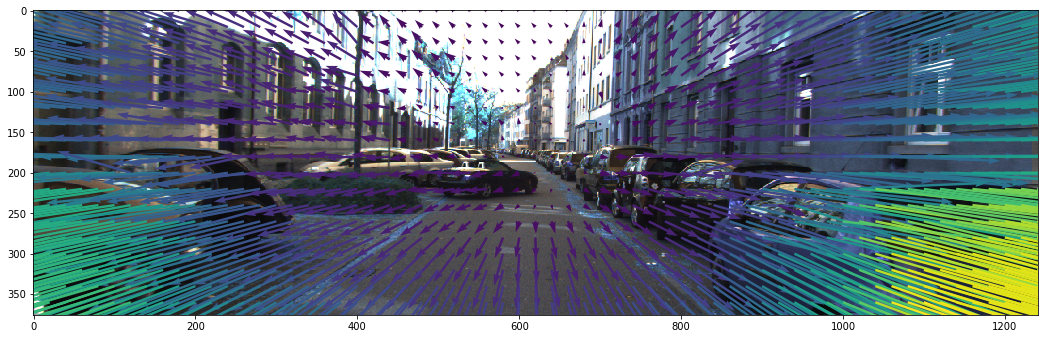

In [14]:
plot_optical_flow_field(seq_path + '000045_10.png',flow)

## OpenCV

### Lucas-Kanade

In [23]:
past_img_gray = cv2.imread(seq_path + '000045_10.png', 0)
current_img_gray = cv2.imread(seq_path + '000045_11.png', 0)

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors
color = np.random.randint(0,255,(100,3))
# Take first frame and find corners in it

p0 = cv2.goodFeaturesToTrack(past_img_gray, mask = None, **feature_params)
# Create a mask image for drawing purposes
mask = np.zeros_like(past_img_gray)

# calculate optical flow
p1, st, err = cv2.calcOpticalFlowPyrLK(past_img_gray, current_img_gray, p0, None, **lk_params)

###  Polynomial Expansion by Farneback

In [15]:
past_img_gray = cv2.imread(seq_path + '000045_10.png', 0)
current_img_gray = cv2.imread(seq_path + '000045_11.png', 0)

s = time.time()
flow = cv2.calcOpticalFlowFarneback(past_img_gray,current_img_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
e = time.time()

print('Time Taken: %.2f seconds for image of size (%d, %d, %d)' % (
    e - s, past_img.shape[0], past_img.shape[1], past_img.shape[2]))

np.save('../task_1-2_results/farnebackflow.npy', flow)

import cv2
hsv = np.zeros(past_img.shape, dtype=np.uint8)
hsv[:, :, 0] = 255
hsv[:, :, 1] = 255
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
hsv[..., 0] = ang * 180 / np.pi / 2
hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
cv2.imwrite('../task_1-2_results/cv_farneback_result.jpg', rgb)
cv2.imwrite('../task_1-2_results/cv_farneback_warped_result.jpg', im2W[:, :, ::-1] * 255)

Time Taken: 0.15 seconds for image of size (376, 1241, 3)


True

In [16]:
flow = [flow[...,0], flow[...,1], gt_flow[2]]

error_msne = flow_msen(gt_flow, flow)
error_pepn = flow_pepn(gt_flow, flow)
print('MSNE: ', error_msne, 'PEPN:', error_pepn)

MSNE:  4.200111936153078 PEPN: 28.393558899645356


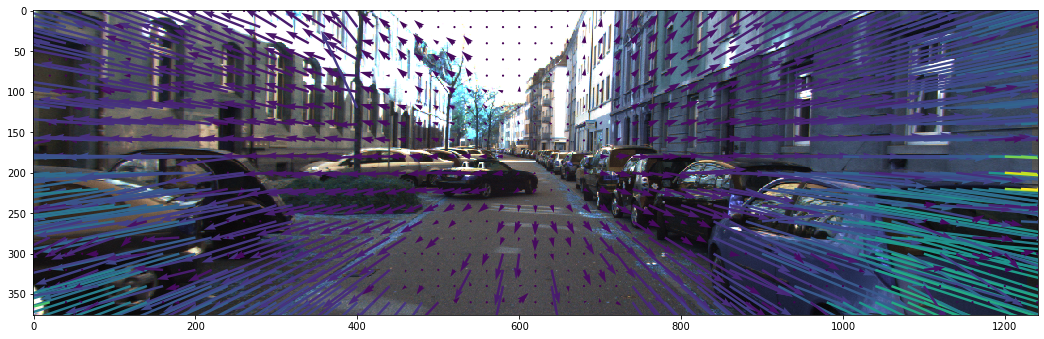

In [17]:
plot_optical_flow_field(seq_path + '000045_10.png',flow)

## Perceiver IO

In [37]:
flow = np.load('../task_1-2_results/45_perceiver_flow.npy')
flow = np.squeeze(flow)

In [38]:
hsv = np.zeros(past_img.shape, dtype=np.uint8)
hsv[:, :, 0] = 255
hsv[:, :, 1] = 255
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
hsv[..., 0] = ang * 180 / np.pi / 2
hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
cv2.imwrite('../task_1-2_results/perceiver_result.jpg', rgb)
cv2.imwrite('../task_1-2_results/perceiver_warped_result.jpg', im2W[:, :, ::-1] * 255)

True

In [36]:
flow = [flow[...,0], flow[...,1], gt_flow[2]]

error_msne = flow_msen(gt_flow, flow)
error_pepn = flow_pepn(gt_flow, flow)
print('MSNE: ', error_msne, 'PEPN:', error_pepn)

MSNE:  0.7425332625061283 PEPN: 4.0745710725582285
